In [87]:
import os
import random

import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seq2seq as s2s  

In [2]:
######## GPU CONFIGS FOR RTX 2070 ###############
## Please ignore if not training on GPU       ##
## this is important for running CuDNN on GPU ##

tf.keras.backend.clear_session() #- for easy reset of notebook state

# chck if GPU can be seen by TF
tf.config.list_physical_devices('GPU')
#tf.debugging.set_log_device_placement(True)  # only to check GPU usage
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
###############################################

1 Physical GPUs, 1 Logical GPU


# Setup Tokenization

In [3]:
tokenizer = tfds.features.text.SubwordTextEncoder.load_from_file("gigaword32k.enc")

In [4]:
# Test tokenizer
txt = "Coronavirus spread surprised everyone"
for ts in tokenizer.encode(txt.lower()):
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

16166 ----> corona
2342 ----> virus 
1980 ----> spread 
7546 ----> surprised 
21092 ----> everyone


In [5]:
# add start and end of sentence tokens
start = tokenizer.vocab_size + 1 
end = tokenizer.vocab_size
print(start, end)

32898 32897


In [6]:
# add start and end of sentence tokens
start = tokenizer.vocab_size + 1 
end = tokenizer.vocab_size
print(start, end)

32898 32897


In [7]:
# Setup tokenization methods
from tensorflow.keras.preprocessing import sequence

def encode(article, summary, start=start, end=end, art_max_len=128, smry_max_len=50):
    tokens = tokenizer.encode(article.numpy())
    if len(tokens) > art_max_len:
        tokens = tokens[:art_max_len]
    tokens = tokens
    pad = sequence.pad_sequences([tokens], padding='post',
                                 maxlen=art_max_len).squeeze()
    art_enc = pad 

    tokens = [start] + tokenizer.encode(summary.numpy())
    if len(tokens) > smry_max_len:
        tokens = tokens[:smry_max_len]
    tokens = tokens + [end]
    pad = sequence.pad_sequences([tokens], padding='post', 
                                 maxlen=smry_max_len).squeeze()
    smry_enc = pad 
  
    return art_enc, smry_enc

def tf_encode(article, summary):
    art_enc, smry_enc = tf.py_function(encode, [article, summary], 
                                     [tf.int64, tf.int64])
    art_enc.set_shape([None])
    smry_enc.set_shape([None])

    return art_enc, smry_enc

# Setup Model

In [8]:
BATCH_SIZE = 1  # for inference
embedding_dim = 128
units = 256  # from pointer generator paper
vocab_size = end + 2

In [9]:
# Create encoder and decoder objects
encoder = s2s.Encoder(vocab_size, embedding_dim, units, BATCH_SIZE)
decoder = s2s.Decoder(vocab_size, embedding_dim, units, BATCH_SIZE)

In [10]:
for layer in decoder.layers:
    print(layer.name)
    
for layer in encoder.layers:
    print(layer.name)

embedding_1
gru_1
fc1
bahdanau_attention
embedding
bidirectional
dense


In [11]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [12]:
# Hydrate the model from saved checkpoint
checkpoint_dir =  'training_checkpoints-2020-Jun-30-09-26-31'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [123]:
# The last training checkpoint
tf.train.latest_checkpoint(checkpoint_dir)

'training_checkpoints-2020-Jun-30-09-26-31/ckpt-17'

In [124]:
chkpt_status = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [125]:
chkpt_status.assert_existing_objects_matched()

# Inference Logic

In [16]:

# function for plotting the attention weights
def plot_attention(attention, article, summary):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    # https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html for scale
    ax.matshow(attention, cmap='cividis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + article, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + summary, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

## Greedy Search

In [17]:
art_max_len = 128
smry_max_len = 50

def greedy_search(article):
    # To store attention plots of the output
    attention_plot = np.zeros((smry_max_len, art_max_len))

    tokens = tokenizer.encode(article) 
    if len(tokens) > art_max_len:
        tokens = tokens[:art_max_len]

    inputs = sequence.pad_sequences([tokens], padding='post',
                                 maxlen=art_max_len).squeeze()
    inputs = tf.expand_dims(tf.convert_to_tensor(inputs), 0)
    
    # output summary tokens will be stored in this
    summary = ''

    hidden = [tf.zeros((1, units)) for i in range(2)] #BiRNN
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([start], 0)

    for t in range(smry_max_len):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)
        
        predicted_id = tf.argmax(predictions[0]).numpy()
        if predicted_id == end:
            return summary, article, attention_plot
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        
        summary += tokenizer.decode([predicted_id])
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return summary, article, attention_plot

In [18]:
# Summarize
def summarize(article, algo='greedy'):
    if algo == 'greedy':
        summary, article, attention_plot = greedy_search(article)
    else:
        print("Algorithm {} not implemented".format(algo))
        return
    
    print('Input: %s' % (article))
    print('** Predicted Summary: {}'.format(summary))

    attention_plot = attention_plot[:len(summary.split(' ')), :len(article.split(' '))]
    plot_attention(attention_plot, article.split(' '), summary.split(' '))

Input: president georgi parvanov summoned france 's ambassador on wednesday in a show of displeasure over comments from french president jacques chirac chiding east european nations for their support of washington on the issue of iraq .
** Predicted Summary: bulgarian president summons french ambassador over remarks on iraq


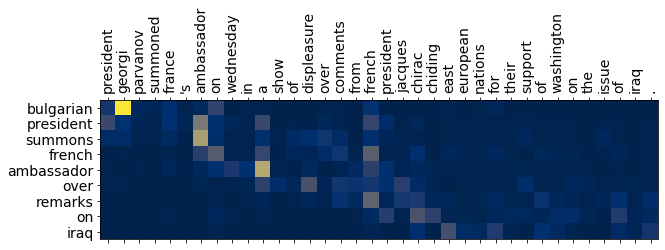

In [19]:
# Test Summarization
txt = "president georgi parvanov summoned france 's ambassador on wednesday in a show of displeasure over comments from french president jacques chirac chiding east european nations for their support of washington on the issue of iraq ."
summarize(txt.lower())

Input: outdoor apparel brand the north face has become the best known company yet to commit to an advertising boycott of facebook in light of the social media platform 's handling of misinformation and hate speech .
** Predicted Summary: outdoor brand web advertisers embrace hate speech


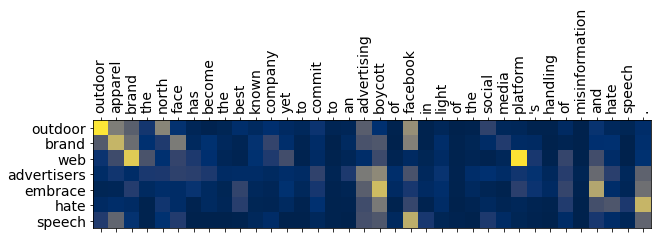

Input: the senate brushed aside an attempt to block renewal of the antiterrorism law known as the usa patriot act thursday , voting ## to # against changes urged by sen. russell d. feingold , the act 's most persistent critic 
** Predicted Summary: senate rejects renewal of patriot act constitutional


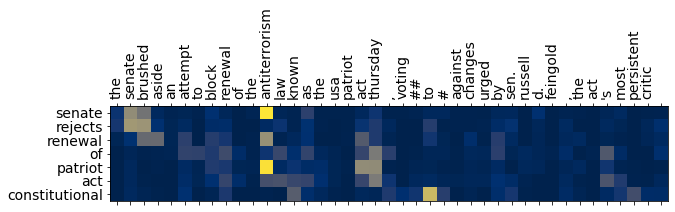

Input: president georgi parvanov summoned france 's ambassador on wednesday in a show of displeasure over comments from french president jacques chirac chiding east european nations for their support of washington on the issue of iraq .
** Predicted Summary: bulgarian president summons french ambassador over remarks on iraq


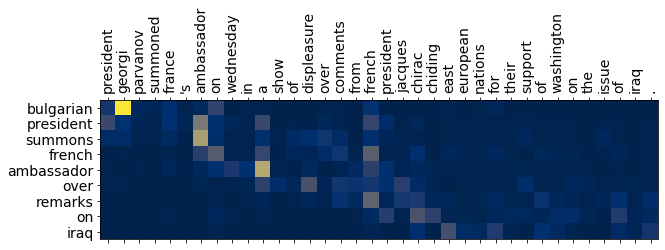

Input: american airlines group inc said on sunday it plans to raise ## billion by selling shares and convertible senior notes , to improve the airline ’s liquidity as it grapples with travel restrictions caused by the coronavirus .
** Predicted Summary: american airlines to raise ## billion convertible notes to improve airline


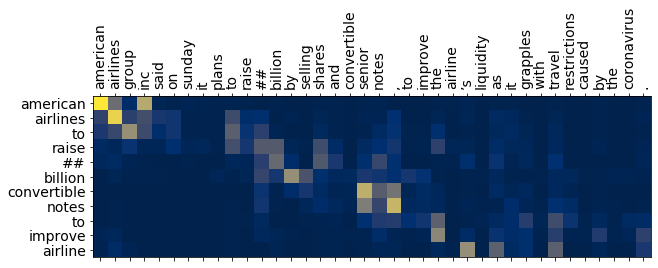

Input: nascar has banned the confederate flag from being displayed at its events , but supporters of the symbol still managed to be seen sunday before the race was postponed to monday because of inclement weather .
** Predicted Summary: nascar bans confederate flag from being canceled


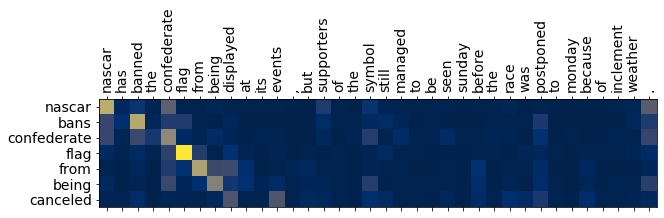

Input: jc penney will close another ## stores for good . the department store chain , which filed for bankruptcy last month , is inching toward its target of closing ## stores .
** Predicted Summary: jc penney to close another ## stores stores for #nd stores


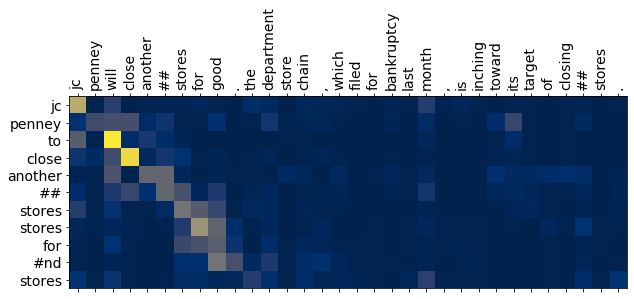

Input: sales of newly-built single-family houses occurred at a seasonally adjusted annual rate of ## in may , that represented a #.# % increase from the downwardly revised pace of ## in april .
** Predicted Summary: new home sales up ## percent in may


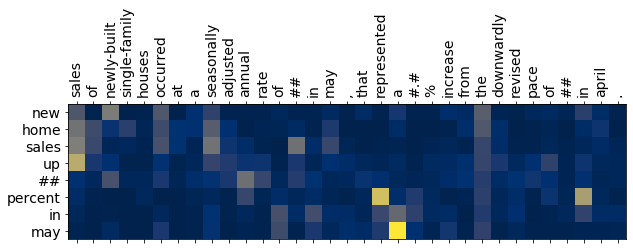

Input: twenty indian troops died in the border skirmish last week , sending china and india into a tense diplomatic and military standoff . indian troops on the border have now been instructed to meet any aggression and transgression by china with equal force , the source told cnn .
** Predicted Summary: china india to meet chinese troops to resolve china border


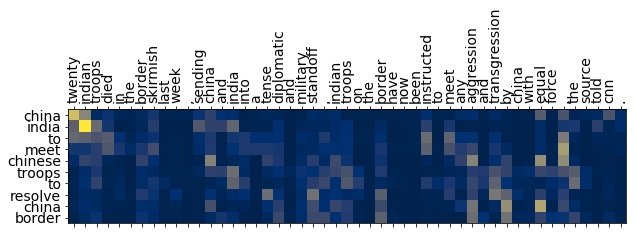

Input: the german engineering giant siemens is working on a revamped version of its defective tram car , of which the ### units sold so far worldwide are being recalled owing to a technical fault , a company spokeswoman said on tuesday .
** Predicted Summary: siemens to launch reb-made cars


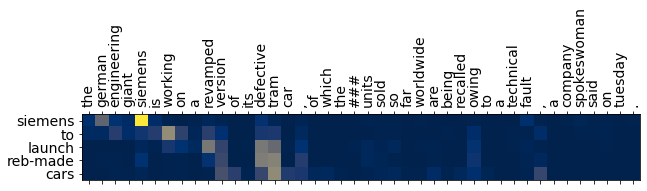

Input: charles kennedy , leader of britain ’s third-ranked liberal democrats , announced saturday he was quitting with immediate effect and would not stand in a new leadership election . us president george w. bush on saturday called for extending tax cuts adopted in his first term , which he said had bolstered economic growth .
** Predicted Summary: kennedy quits to be a step toward new term


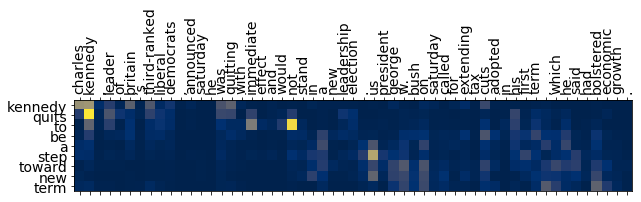

Input: senate democrats block republicans proposal to overhaul us policing practices , contending the measure is too meager .
** Predicted Summary: senate democrats block republicans to overhaul us policing procedures


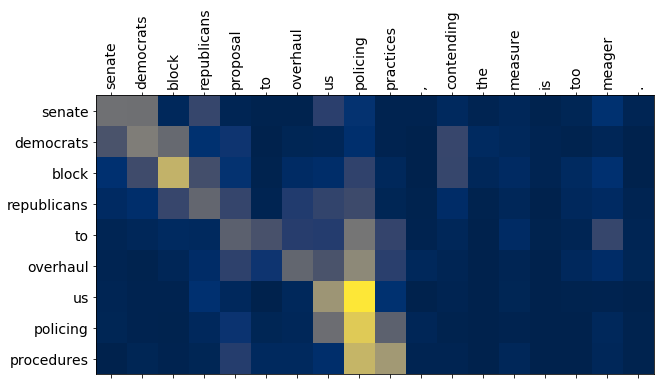

In [20]:
txt = "Outdoor apparel brand The North Face has become the best known company yet to commit to an advertising boycott of Facebook in light of the social media platform 's handling of misinformation and hate speech ."
summarize(txt.lower())

txt = "the senate brushed aside an attempt to block renewal of the antiterrorism law known as the usa patriot act thursday , voting ## to # against changes urged by sen. russell d. feingold , the act 's most persistent critic "
summarize(txt.lower())

txt = "president georgi parvanov summoned france 's ambassador on wednesday in a show of displeasure over comments from french president jacques chirac chiding east european nations for their support of washington on the issue of iraq ."
summarize(txt.lower())

txt = "American Airlines Group Inc said on Sunday it plans to raise ## billion by selling shares and convertible senior notes , to improve the airline ’s liquidity as it grapples with travel restrictions caused by the coronavirus ."
summarize(txt.lower())

txt = "NASCAR has banned the Confederate flag from being displayed at its events , but supporters of the symbol still managed to be seen Sunday before the race was postponed to Monday because of inclement weather ."
summarize(txt.lower())

txt = "JC Penney will close another ## stores for good . The department store chain , which filed for bankruptcy last month , is inching toward its target of closing ## stores ."
summarize(txt.lower())

txt="Sales of newly-built single-family houses occurred at a seasonally adjusted annual rate of ## in May , that represented a #.# % increase from the downwardly revised pace of ## in April ."
summarize(txt.lower())

txt = "Twenty Indian troops died in the border skirmish last week , sending China and India into a tense diplomatic and military standoff . Indian troops on the border have now been instructed to meet any aggression and transgression by China with equal force , the source told CNN ."
summarize(txt.lower())

txt = "the german engineering giant siemens is working on a revamped version of its defective tram car , of which the ### units sold so far worldwide are being recalled owing to a technical fault , a company spokeswoman said on tuesday ."
summarize(txt.lower())

txt = "charles kennedy , leader of britain ’s third-ranked liberal democrats , announced saturday he was quitting with immediate effect and would not stand in a new leadership election . us president george w. bush on saturday called for extending tax cuts adopted in his first term , which he said had bolstered economic growth ."
summarize(txt.lower())

txt = "senate democrats block republicans proposal to overhaul US policing practices , contending the measure is too meager ."
summarize(txt.lower())

## Beam Search

In [22]:
# Beam search implementation
def beam_search(article, beam_width=3, 
                         art_max_len=128, 
                         smry_max_len=50,
                         end_tk=end,
                         verbose=True):
    attention_plot = np.zeros((smry_max_len, art_max_len))

    tokens = tokenizer.encode(article)  #no adding start
    if len(tokens) > art_max_len:
        tokens = tokens[:art_max_len]

    inputs = sequence.pad_sequences([tokens], padding='post',
                                 maxlen=art_max_len).squeeze()

    inputs = tf.expand_dims(tf.convert_to_tensor(inputs), 0)
    #print(inputs.shape)

    hidden = [tf.zeros((1, units)) for i in range(2)] #BiRNN
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([start], 0)
    
    # initial beam with (tokens, last hidden state, attn, score)
    start_pt = [([start], dec_hidden, attention_plot, 0.0)]  # initial beam 
    
    for t in range(smry_max_len):
        options = list() # empty list to store candidates
        for row in start_pt:
            # handle beams emitting end signal
            allend = True
            dec_input = row[0][-1]
            if dec_input != end_tk:
                dec_input = tf.expand_dims([dec_input], 0)  # last token
    
                dec_hidden = row[1]  # second item is hidden states
                attn_plt = np.zeros((smry_max_len, art_max_len)) +\
                           row[2] # new attn vector
                
                predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                                 dec_hidden,
                                                                 enc_out)
    
                # storing the attention weights to plot later on
                attention_weights = tf.reshape(attention_weights, (-1, ))
                attn_plt[t] = attention_weights.numpy() 
                
                # take top-K in this beam
                values, indices = tf.math.top_k(predictions[0], k=beam_width)
                for tokid, scre in zip(indices, values):
                    score = row[3] - np.log(scre)
                    options.append((row[0]+[tokid], dec_hidden, attn_plt, score))
                allend=False
            else:
                options.append(row)  # add ended beams back in
        
        if allend:
            break # end for loop as all sequences have ended
    
        start_pt = sorted(options, key=lambda tup:tup[3])[:beam_width]
    
    if verbose:
        # print all the final summaries
        for idx, row in enumerate(start_pt):
            tokens = [x for x in row[0] if x < end_tk]
            print("Summary {} with {:5f}: {}".format(idx, row[3], 
                                          tokenizer.decode(tokens)))
    # return final sequence    
    summary = tokenizer.decode([x for x in start_pt[0][0] if x < end_tk])
    attention_plot = start_pt[0][2]  # third item in tuple
    return summary, article, attention_plot

In [23]:
# Summarize
def summarize(article, algo='greedy', beam_width=3, verbose=True):
    if algo == 'greedy':
        summary, article, attention_plot = greedy_search(article)
    elif algo=='beam':
        summary, article, attention_plot = beam_search(article, 
                                                    beam_width=beam_width,
                                                    verbose=verbose)
    else:
        print("Algorithm {} not implemented".format(algo))
        return
    
    print('Input: %s' % (article))
    print('** Predicted Summary: {}'.format(summary))

    attention_plot = attention_plot[:len(summary.split(' ')), 
                                    :len(article.split(' '))]
    plot_attention(attention_plot, article.split(' '), 
                   summary.split(' '))

Summary 0 with 4.028967: bulgarian president summons french ambassador
Summary 1 with 6.104148: bulgarian president summons french ambassador over u.s. 
Summary 2 with 6.456773: bulgarian president summons french ambassador over remarks on iraq
Input: president georgi parvanov summoned france 's ambassador on wednesday in a show of displeasure over comments from french president jacques chirac chiding east european nations for their support of washington on the issue of iraq .
** Predicted Summary: bulgarian president summons french ambassador


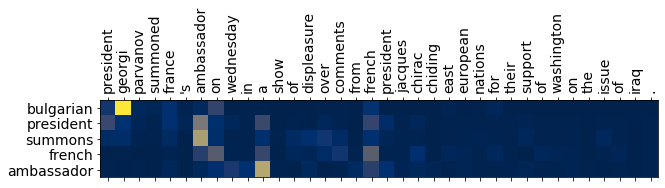

In [24]:
# Test beam search
txt = "president georgi parvanov summoned france 's ambassador on wednesday in a show of displeasure over comments from french president jacques chirac chiding east european nations for their support of washington on the issue of iraq ."
summarize(txt.lower(), algo='beam', beam_width=3)

Input: president georgi parvanov summoned france 's ambassador on wednesday in a show of displeasure over comments from french president jacques chirac chiding east european nations for their support of washington on the issue of iraq .
** Predicted Summary: bulgarian president summons french ambassador over remarks on iraq


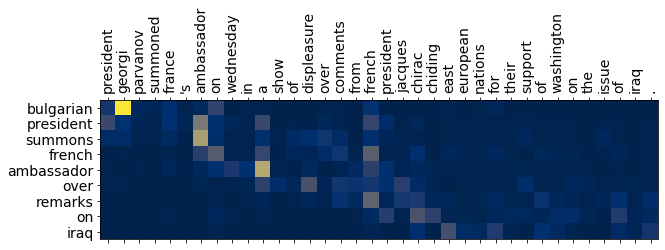

Summary 0 with 4.028967: bulgarian president summons french ambassador
Summary 1 with 6.104148: bulgarian president summons french ambassador over u.s. 
Summary 2 with 6.456773: bulgarian president summons french ambassador over remarks on iraq
Input: president georgi parvanov summoned france 's ambassador on wednesday in a show of displeasure over comments from french president jacques chirac chiding east european nations for their support of washington on the issue of iraq .
** Predicted Summary: bulgarian president summons french ambassador


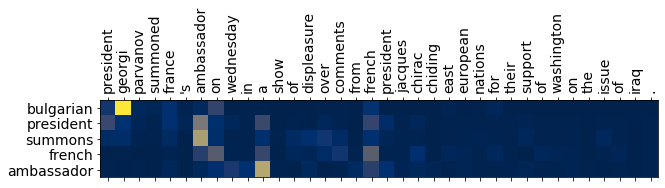

Input: american airlines group inc said on sunday it plans to raise ## billion by selling shares and convertible senior notes , to improve the airline ’s liquidity as it grapples with travel restrictions caused by the coronavirus .
** Predicted Summary: american airlines to raise ## billion convertible notes to improve airline


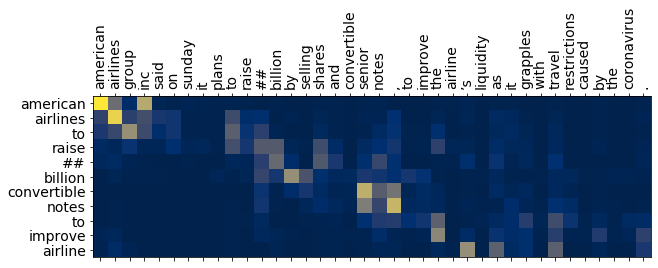

Summary 0 with 4.366627: american airlines to raise ## billion convertible notes
Summary 1 with 6.423662: american airlines to raise ## billion convertible notes to improve airline
Summary 2 with 6.651283: american airlines to raise ## bln notes notes to improve airline
Input: american airlines group inc said on sunday it plans to raise ## billion by selling shares and convertible senior notes , to improve the airline ’s liquidity as it grapples with travel restrictions caused by the coronavirus .
** Predicted Summary: american airlines to raise ## billion convertible notes


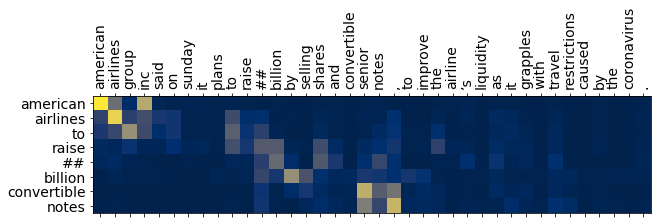

Input: nascar has banned the confederate flag from being displayed at its events , but supporters of the symbol still managed to be seen sunday before the race was postponed to monday because of inclement weather .
** Predicted Summary: nascar bans confederate flag from being canceled


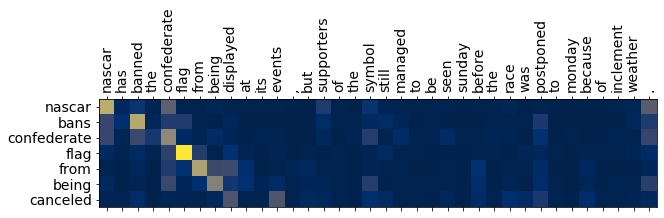

Summary 0 with 2.158855: nascar bans confederate flag
Summary 1 with 4.869565: nascar bans confederate flag from being canceled
Summary 2 with 4.879776: nascar bans confederate flag from flag
Input: nascar has banned the confederate flag from being displayed at its events , but supporters of the symbol still managed to be seen sunday before the race was postponed to monday because of inclement weather .
** Predicted Summary: nascar bans confederate flag


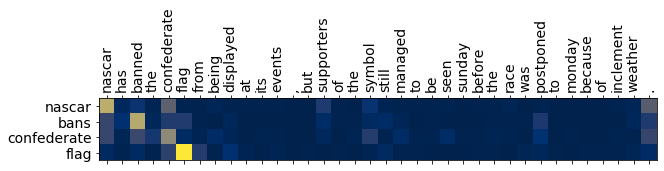

Input: jc penney will close another ## stores for good . the department store chain , which filed for bankruptcy last month , is inching toward its target of closing ## stores .
** Predicted Summary: jc penney to close another ## stores stores for #nd stores


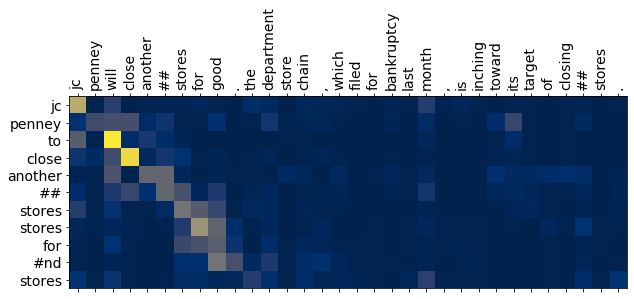

Summary 0 with 3.416048: jc penney to close ## more stores
Summary 1 with 4.052623: jc penney to close another ## stores
Summary 2 with 8.338362: jc penney to close another ## stores stores for #nd stores
Input: jc penney will close another ## stores for good . the department store chain , which filed for bankruptcy last month , is inching toward its target of closing ## stores .
** Predicted Summary: jc penney to close ## more stores


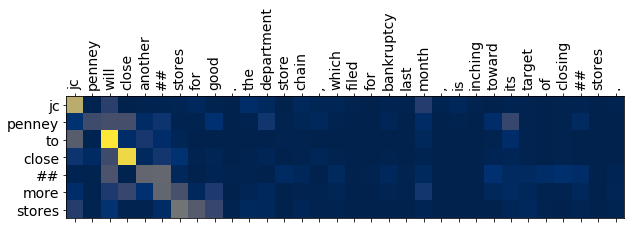

Input: sales of newly - built single - family houses occurred at a seasonally adjusted annual rate of ## in may , that represented a #.# % increase from the downwardly revised pace of ## in april .
** Predicted Summary: new home sales up ## percent in may


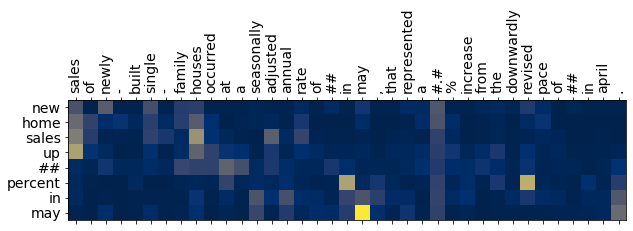

Summary 0 with 5.984827: new home sales up ## percent in may
Summary 1 with 6.334815: new home sales down ## percent in may
Summary 2 with 15.855973: new-family single-building single-building housing market index shows
Input: sales of newly - built single - family houses occurred at a seasonally adjusted annual rate of ## in may , that represented a #.# % increase from the downwardly revised pace of ## in april .
** Predicted Summary: new home sales up ## percent in may


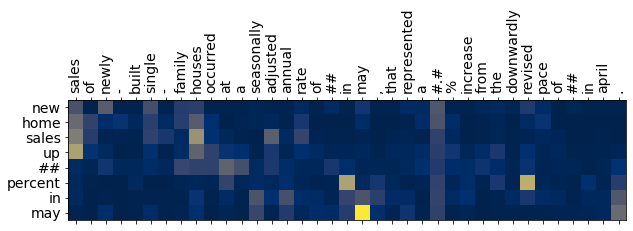

Input: twenty indian troops died in the border skirmish last week , sending china and india into a tense diplomatic and military standoff . indian troops on the border have now been instructed to meet any aggression and transgression by china with equal force , the source told cnn .
** Predicted Summary: china india to meet chinese troops to resolve china border


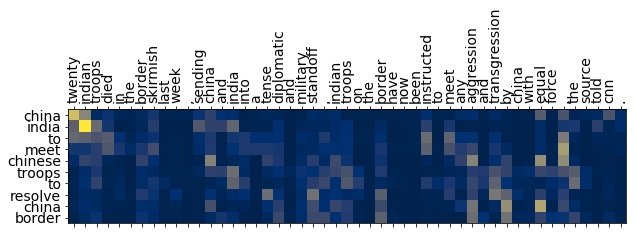

Summary 0 with 9.966088: ## indian troops killed in border skirmish in border clash
Summary 1 with 10.452483: ## indian troops killed in border skirmish with UNK
Summary 2 with 14.111279: ## indian troops killed in border skirmish in border skirmish with india
Input: twenty indian troops died in the border skirmish last week , sending china and india into a tense diplomatic and military standoff . indian troops on the border have now been instructed to meet any aggression and transgression by china with equal force , the source told cnn .
** Predicted Summary: ## indian troops killed in border skirmish in border clash


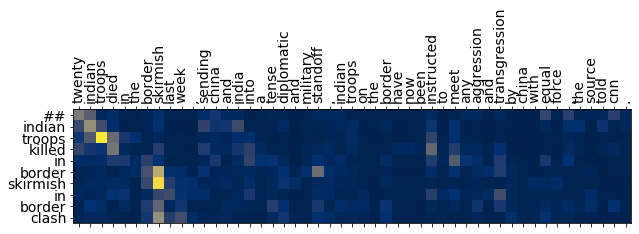

Input: the german engineering giant siemens is working on a revamped version of its defective tram car , of which the ### units sold so far worldwide are being recalled owing to a technical fault , a company spokeswoman said on tuesday .
** Predicted Summary: siemens to launch reb-made cars


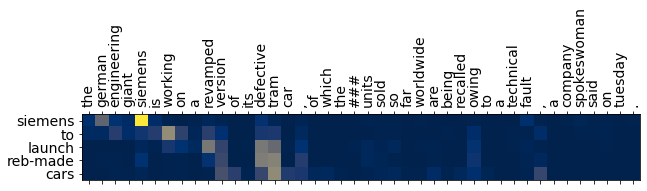

Summary 0 with 5.260820: siemens working on revamped european tram car
Summary 1 with 5.460233: siemens working on revamped german tram car
Summary 2 with 15.324270: siemens working on new version of launch of launch of launch of defective tram car
Input: the german engineering giant siemens is working on a revamped version of its defective tram car , of which the ### units sold so far worldwide are being recalled owing to a technical fault , a company spokeswoman said on tuesday .
** Predicted Summary: siemens working on revamped european tram car


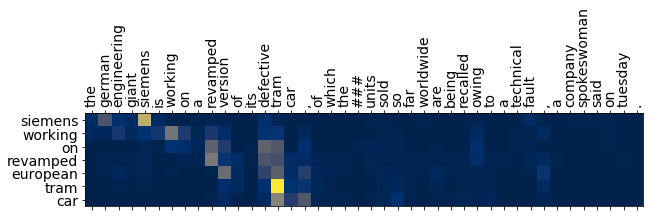

Input: charles kennedy , leader of britain ’s third-ranked liberal democrats , announced saturday he was quitting with immediate effect and would not stand in a new leadership election . us president george w. bush on saturday called for extending tax cuts adopted in his first term , which he said had bolstered economic growth .
** Predicted Summary: kennedy quits to be a step toward new term


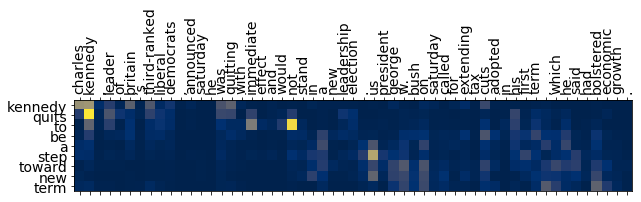

Summary 0 with 10.355200: bush kennedy quits as bush calls for tax cuts
Summary 1 with 11.425583: bush kennedy quits as bush seeks tax cuts
Summary 2 with 11.848074: bush kennedy quits as bush calls for extending tax cuts
Input: charles kennedy , leader of britain ’s third-ranked liberal democrats , announced saturday he was quitting with immediate effect and would not stand in a new leadership election . us president george w. bush on saturday called for extending tax cuts adopted in his first term , which he said had bolstered economic growth .
** Predicted Summary: bush kennedy quits as bush calls for tax cuts


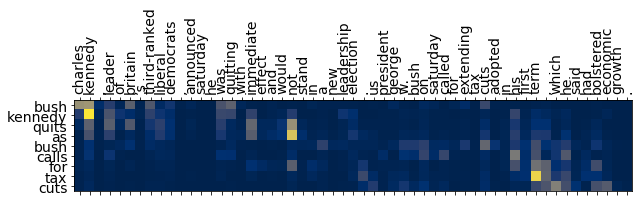

Input: senate democrats block republicans proposal to overhaul us policing practices , contending the measure is too meager .
** Predicted Summary: senate democrats block republicans to overhaul us policing procedures


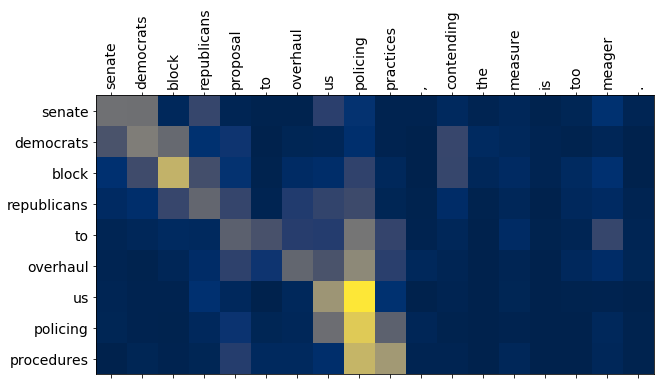

Summary 0 with 14.583007: senate democrats block republican overhaul of us policing in us congress
Summary 1 with 16.084537: us senate democrats block us overhaul of us policing in us congress
Summary 2 with 18.113342: us senate democrats block us overhaul of us policing in us senate vote
Input: senate democrats block republicans proposal to overhaul us policing practices , contending the measure is too meager .
** Predicted Summary: senate democrats block republican overhaul of us policing in us congress


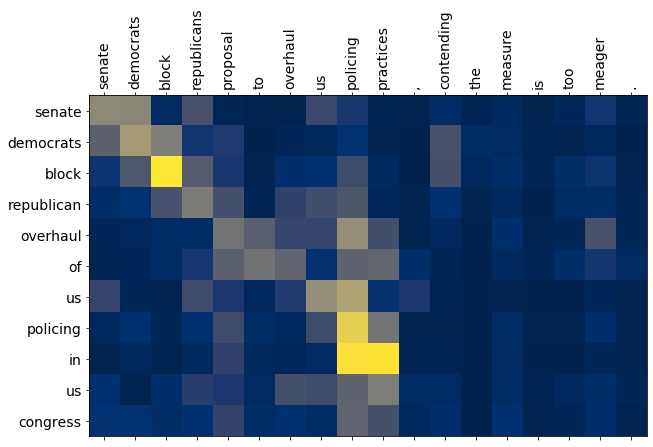

'senate democrats block republican overhaul of us policing in us congress'

In [104]:
bm_wd = 3

txt = "president georgi parvanov summoned france 's ambassador on wednesday in a show of displeasure over comments from french president jacques chirac chiding east european nations for their support of washington on the issue of iraq ."
summarize(txt.lower())
summarize(txt.lower(), algo='beam', beam_width=bm_wd)

txt = "American Airlines Group Inc said on Sunday it plans to raise ## billion by selling shares and convertible senior notes , to improve the airline ’s liquidity as it grapples with travel restrictions caused by the coronavirus ."
summarize(txt.lower())
summarize(txt.lower(), algo='beam', beam_width=bm_wd)

txt = "NASCAR has banned the Confederate flag from being displayed at its events , but supporters of the symbol still managed to be seen Sunday before the race was postponed to Monday because of inclement weather ."
summarize(txt.lower())
summarize(txt.lower(), algo='beam', beam_width=bm_wd)

txt = "JC Penney will close another ## stores for good . The department store chain , which filed for bankruptcy last month , is inching toward its target of closing ## stores ."
summarize(txt.lower())
summarize(txt.lower(), algo='beam', beam_width=bm_wd)

txt="Sales of newly - built single - family houses occurred at a seasonally adjusted annual rate of ## in May , that represented a #.# % increase from the downwardly revised pace of ## in April ."
summarize(txt.lower())
summarize(txt.lower(), algo='beam', beam_width=bm_wd)

txt = "Twenty Indian troops died in the border skirmish last week , sending China and India into a tense diplomatic and military standoff . Indian troops on the border have now been instructed to meet any aggression and transgression by China with equal force , the source told CNN ."
summarize(txt.lower())
summarize(txt.lower(), algo='beam', beam_width=bm_wd)

txt = "the german engineering giant siemens is working on a revamped version of its defective tram car , of which the ### units sold so far worldwide are being recalled owing to a technical fault , a company spokeswoman said on tuesday ."
summarize(txt.lower())
summarize(txt.lower(), algo='beam', beam_width=bm_wd)

txt = "charles kennedy , leader of britain ’s third-ranked liberal democrats , announced saturday he was quitting with immediate effect and would not stand in a new leadership election . us president george w. bush on saturday called for extending tax cuts adopted in his first term , which he said had bolstered economic growth ."
summarize(txt.lower())
summarize(txt.lower(), algo='beam', beam_width=bm_wd)

txt = "senate democrats block republicans proposal to overhaul US policing practices , contending the measure is too meager ."
summarize(txt.lower())
summarize(txt.lower(), algo='beam', beam_width=bm_wd)

## Beam Search with Length Normalization

In [77]:
def length_wu(step, score, alpha=0.):
    # NMT length re-ranking score from
    # "Google's Neural Machine Translation System" paper by Wu et al
    modifier = (((5 + step) ** alpha) /
                ((5 + 1) ** alpha))
    return (score / modifier)

In [64]:
# Beam search implementation with normalization
def beam_search_norm(article, beam_width=3, 
                         art_max_len=128, 
                         smry_max_len=50,
                         end_tk=end,
                         alpha=0.,
                         verbose=True):
    attention_plot = np.zeros((smry_max_len, art_max_len))
    
    tokens = tokenizer.encode(article)  #no adding start
    if len(tokens) > art_max_len:
        tokens = tokens[:art_max_len]

    inputs = sequence.pad_sequences([tokens], padding='post',
                                 maxlen=art_max_len).squeeze()

    inputs = tf.expand_dims(tf.convert_to_tensor(inputs), 0)

    hidden = [tf.zeros((1, units)) for i in range(2)] #BiRNN
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([start], 0)
    
    # (tokens, last hidden state, attn, score)
    start_pt = [([start], dec_hidden, attention_plot, 0.0)]  # initial beam 
    
    for t in range(smry_max_len):
        options = list() # empty list to store candidates
        for row in start_pt:
            # handle beams emitting end signal
            allend = True
            dec_input = row[0][-1]
            if dec_input != end_tk:
                dec_input = tf.expand_dims([dec_input], 0)  # last token

                dec_hidden = row[1]  # second item is hidden states
                attn_plt = np.zeros((smry_max_len, art_max_len)) +\
                               row[2] # new attn vector
                 
                assert id(attn_plt) is not id(row[2]) # new object
                predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                                 dec_hidden,
                                                                 enc_out)

                # check hidden states
                assert id(dec_hidden) is not id(row[1])
                # storing the attention weights to plot later on
                attention_weights = tf.reshape(attention_weights, (-1, ))
                attn_plt[t] = attention_weights.numpy()
                
                # take top-K in this beam
                values, indices = tf.math.top_k(predictions[0], k=beam_width)
                for tokid, scre in zip(indices, values):
                    score = row[3] - np.log(scre) 
                    score = length_wu(t, score, alpha)
                    options.append((row[0]+[tokid], dec_hidden, 
                                    attn_plt, score))
                allend=False
            else:
                options.append(row)
        
        if allend:
            break # end for loop as all sequences have ended

        start_pt = sorted(options, key=lambda tup:tup[3])[:beam_width]
    if verbose:
        # print all the final summaries
        for idx, row in enumerate(start_pt):
            tokens = [x for x in row[0] if x < end_tk]
            print("Summary {} with score {:5f}: {}".format(idx, 
                                          row[3],
                                          tokenizer.decode(tokens)))

    # return final sequence    
    summary = tokenizer.decode([x for x in start_pt[0][0] if x < end_tk])
    attention_plot = start_pt[0][2]  # third item in tuple
    return summary, article, attention_plot

In [62]:
# Summarize
def summarize(article, algo='greedy', beam_width=3, alpha=0., 
              verbose=True):
    if algo == 'greedy':
        summary, article, attention_plot = greedy_search(article)
    elif algo=='beam':
        summary, article, attention_plot = beam_search(article, 
                                                    beam_width=beam_width,
                                                    verbose=verbose)
    elif algo=='beam-norm':
        summary, article, attention_plot = beam_search_norm(article, 
                                                    beam_width=beam_width,
                                                    alpha=alpha,
                                                    verbose=verbose)
    else:
        print("Algorithm {} not implemented".format(algo))
        return
    if verbose:
        print('Input: %s' % (article))
        print('** Predicted Summary: {}'.format(summary))

        attention_plot = attention_plot[:len(summary.split(' ')), :len(article.split(' '))]
        plot_attention(attention_plot, article.split(' '), summary.split(' '))
    return summary

Summary 0 with score 6.423662: american airlines to raise ## billion convertible notes to improve airline
Input: american airlines group inc said on sunday it plans to raise ## billion by selling shares and convertible senior notes , to improve the airline ’s liquidity as it grapples with travel restrictions caused by the coronavirus .
** Predicted Summary: american airlines to raise ## billion convertible notes to improve airline


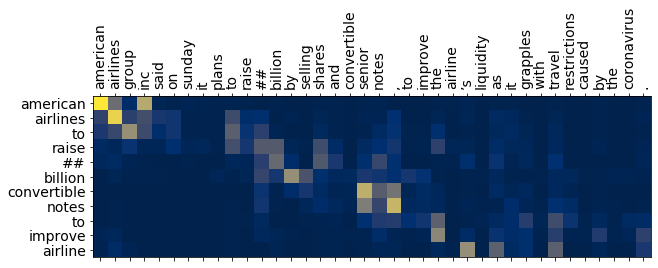

Summary 0 with score 4.366627: american airlines to raise ## billion convertible notes
Summary 1 with score 6.423662: american airlines to raise ## billion convertible notes to improve airline
Summary 2 with score 6.651283: american airlines to raise ## bln notes notes to improve airline
Input: american airlines group inc said on sunday it plans to raise ## billion by selling shares and convertible senior notes , to improve the airline ’s liquidity as it grapples with travel restrictions caused by the coronavirus .
** Predicted Summary: american airlines to raise ## billion convertible notes


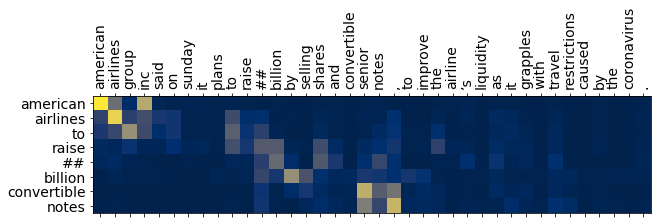

Summary 0 with score 0.593230: american airlines plans to raise ## billion convertible notes to improve airline
Summary 1 with score 0.676442: american airlines to raise ## billion convertible notes to improve airline
Summary 2 with score 1.080701: american airlines plans to raise ## billion convertible notes
Input: american airlines group inc said on sunday it plans to raise ## billion by selling shares and convertible senior notes , to improve the airline ’s liquidity as it grapples with travel restrictions caused by the coronavirus .
** Predicted Summary: american airlines plans to raise ## billion convertible notes to improve airline


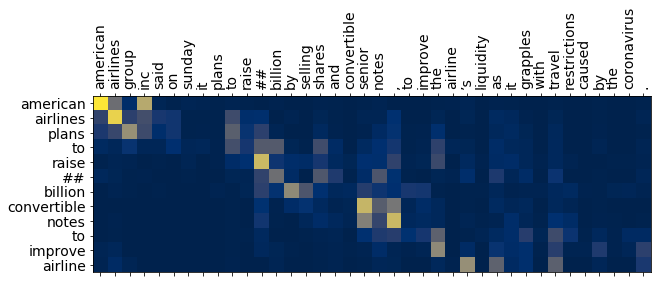

'american airlines plans to raise ## billion convertible notes to improve airline'

In [66]:
txt = "American Airlines Group Inc said on Sunday it plans to raise ## billion by selling shares and convertible senior notes , to improve the airline ’s liquidity as it grapples with travel restrictions caused by the coronavirus ."
summarize(txt.lower(), algo='beam-norm', beam_width=1)
summarize(txt.lower(), algo='beam-norm', beam_width=3)
summarize(txt.lower(), algo='beam-norm', beam_width=3, alpha=0.6)

Summary 0 with score 5.626832: siemens working on revamped german tram 
Summary 1 with score 6.528699: siemens working for revamped german tram 
Summary 2 with score 6.925321: siemens working on revamped european tram 
Summary 3 with score 7.694374: siemens working on revamped UNK tram 
Summary 4 with score 8.584188: siemens working on revamped german tram
Input: the german engineering giant siemens is working on a revamped version of its defective tram car , of which the ### units sold so far worldwide are being recalled owing to a technical fault , a company spokeswoman said on tuesday .
** Predicted Summary: siemens working on revamped german tram 


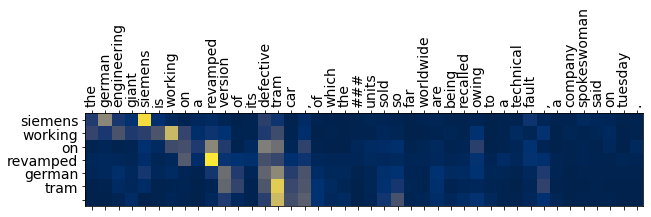

Summary 0 with score 1.446876: siemens working on revamped german tram 
Summary 1 with score 1.598424: siemens working for revamped german tram 
Summary 2 with score 1.862136: siemens working on revamped european tram 
Summary 3 with score 2.198000: siemens working on revamped UNK tram 
Summary 4 with score 2.920415: siemens working on revamped UNK tram
Input: the german engineering giant siemens is working on a revamped version of its defective tram car , of which the ### units sold so far worldwide are being recalled owing to a technical fault , a company spokeswoman said on tuesday .
** Predicted Summary: siemens working on revamped german tram 


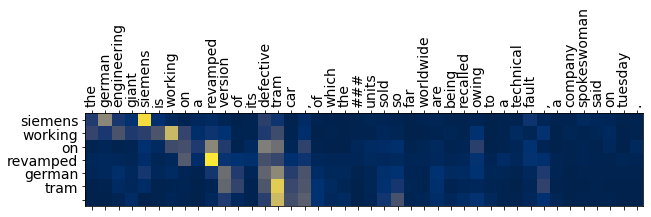

'siemens working on revamped german tram '

In [128]:
txt = "the german engineering giant siemens is working on a revamped version of its defective tram car , of which the ### units sold so far worldwide are being recalled owing to a technical fault , a company spokeswoman said on tuesday ."
summarize(txt.lower(), algo='beam-norm', beam_width=5, alpha=0.)
summarize(txt.lower(), algo='beam-norm', beam_width=5, alpha=0.8)

Input: the uk on friday said that it would allow a quarantine-free international travel to some low-risk countries falling in its green zone list of an estimated ## nations . uk transport secretary said that the us will fall within the red zone .
** Predicted Summary: uk to allow free travel to low-risk countries


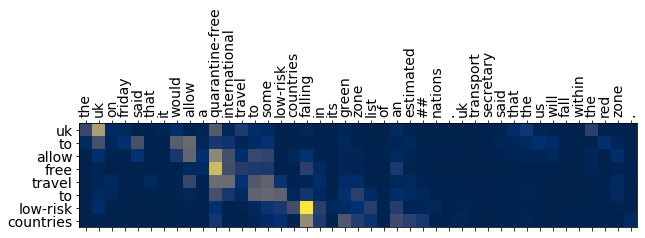

Summary 0 with score 6.968123: britain to allow free travel to low-risk countries
Summary 1 with score 7.874951: uk to allow free travel to low-risk countries
Summary 2 with score 8.237040: britain to allow free trade travel to low-risk countries
Summary 3 with score 8.401402: britain to allow quarantines free travel to low-risk countries
Summary 4 with score 13.331364: britain to allow quarantines free travel to low-risk countries to green zone
Input: the uk on friday said that it would allow a quarantine-free international travel to some low-risk countries falling in its green zone list of an estimated ## nations . uk transport secretary said that the us will fall within the red zone .
** Predicted Summary: britain to allow free travel to low-risk countries


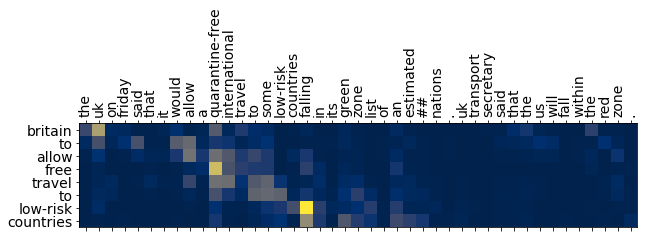

Summary 0 with score 0.243352: britain to allow quarantines free travel to low-risk countries
Summary 1 with score 0.316381: britain to allow free trade travel to low-risk countries
Summary 2 with score 0.397716: britain to allow free travel to low-risk countries
Summary 3 with score 0.421311: uk to allow free travel to low-risk countries
Summary 4 with score 0.511316: britain to allow quarantines free travel to low-risk countries to green zone
Input: the uk on friday said that it would allow a quarantine-free international travel to some low-risk countries falling in its green zone list of an estimated ## nations . uk transport secretary said that the us will fall within the red zone .
** Predicted Summary: britain to allow quarantines free travel to low-risk countries


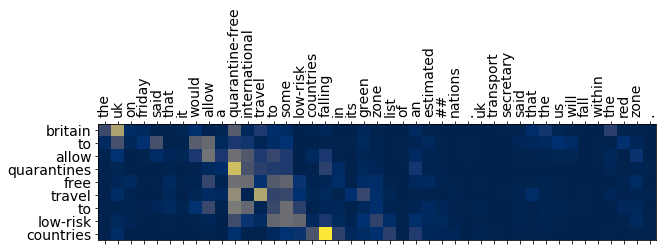

'britain to allow quarantines free travel to low-risk countries'

In [111]:
txt = "The UK on Friday said that it would allow a quarantine-free international travel to some low-risk countries falling in its green zone list of an estimated ## nations . UK transport secretary said that the US will fall within the red zone ."
summarize(txt.lower())
summarize(txt.lower(), algo='beam-norm', beam_width=5)
summarize(txt.lower(), algo='beam-norm', beam_width=5, alpha=0.7)

# ROUGE Evaluation

In [78]:
from rouge_score import rouge_scorer as rs

In [79]:
scorer = rs.RougeScorer(['rougeL'], use_stemmer=True)

In [85]:
# Summarize
def summarize_quietly(article, algo='greedy', beam_width=3, 
                      alpha=0., verbose=False):
    if algo == 'greedy':
        summary, article, attention_plot = greedy_search(article)
    elif algo=='beam':
        summary, article, attention_plot = beam_search(article, 
                                                    beam_width=beam_width)
    elif algo=='beam-norm':
        summary, article, attention_plot = beam_search_norm(article, 
                                                    beam_width=beam_width,
                                                    alpha=alpha,
                                                    verbose=verbose)
    else:
        print("Algorithm {} not implemented".format(algo))
        return
    
    return summary

In [82]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
        'gigaword',
        split=['train', 'validation', 'test'],
        shuffle_files=True,
        as_supervised=True,
        with_info=True,
    )

## Greedy Search ROUGE Evaluation

In [97]:
# total eval size: 189651
articles = 1000
f1 = 0.
prec = 0.
rec = 0.
beam_width = 1

for art, smm in ds_val.take(articles):
    summ = summarize_quietly(str(art.numpy()), algo='beam-norm', 
                             beam_width=1, verbose=False)
    score = scorer.score(str(smm.numpy()), summ)
    f1 += score['rougeL'].fmeasure / articles
    prec += score['rougeL'].precision / articles
    rec += score['rougeL'].recall / articles
    # see if a sample needs to be printed
    if random.choices((True, False), [1, 99])[0] is True: #1% samples printed out
        print("Article: ", art.numpy())
        print("Ground Truth: ", smm.numpy())
        print("Greedy Summary: ", summarize_quietly(str(art.numpy()), algo='beam-norm', 
                             beam_width=1, verbose=False))
        print("Beam Search Summary :", summ, "\n")

print("Precision: {:.6f}, Recall: {:.6f}, F1-Score: {:.6f}".format(prec, rec, f1))

Article:  b"with canada 's parliament election three days away , a new poll released friday shows the main parties are in a neck-and-neck situation ."
Ground Truth:  b"canada 's election race expected to be dead heat"
Greedy Summary:  in poll
Beam Search Summary : in poll 

Article:  b'candice wiggins scored ## points and nicky UNK had ## points and ## rebounds to lead the minnesota lynx to a ##-## win over the atlanta dream on tuesday night .'
Ground Truth:  b'wiggins leads lynx over atlanta'
Greedy Summary:  lynx homers twice as a lead over atlanta dream in game
Beam Search Summary : lynx homers twice as a lead over atlanta dream in game 

Article:  b'meeting in their last debate before more than a dozen states vote in primaries on tuesday , vice president al gore and former sen. bill bradley appeared uncharacteristically harmonious together wednesday night , going out of their way to agree on virtually every issue and avoiding the kind of attacks that characterized their raucous deb

## Beam Search ROUGE Evaluation 

In [98]:
# With Beam size of 3
# total eval size: 189651
articles = 1000
f1 = 0.
prec = 0.
rec = 0.

for art, smm in ds_val.take(articles):
    summ = summarize_quietly(str(art.numpy()), algo='beam-norm', 
                             beam_width=3, verbose=False)
    score = scorer.score(str(smm.numpy()), summ)
    f1 += score['rougeL'].fmeasure / articles
    prec += score['rougeL'].precision / articles
    rec += score['rougeL'].recall / articles
    # see if a sample needs to be printed
    if random.choices((True, False), [1, 99])[0] is True: #1%
        print("Article: ", art.numpy())
        print("Ground Truth: ", smm.numpy())
        print("Greedy Summary: ", summarize_quietly(str(art.numpy()), algo='beam-norm', 
                             beam_width=1, verbose=False))
        print("Beam Search Summary :", summ, "\n")

print("Precision: {:.6f}, Recall: {:.6f}, F1-Score: {:.6f}".format(prec, rec, f1))

Article:  b'citigroup said wednesday that it will start its ##.#-billion-dollar takeover bid for the scandal-hit japanese securities firm nikko cordial on thursday , betting investors will accept its higher offer .'
Ground Truth:  b'citigroup to launch nikko cordial buyout thursday'
Greedy Summary:  b.
Beam Search Summary : b. 

Article:  b"dane nicolas UNK made his formula one debut for minardi here friday but failed to get more than a few metres out of the UNK in qualifying for sunday 's german grand prix ."
Ground Truth:  b'UNK puts debut error down to inexperience'
Greedy Summary:  UNK misses formula one grand prix
Beam Search Summary : UNK misses f# debut 

Article:  b'israeli warplanes attacked a village in eastern lebanon and the edge palestinian refugee camp monday leaving two people dead and nine wounded , security officials said .'
Ground Truth:  b'israeli air raids kill and wound dozens in eastern lebanon before cease-fire takes hold'
Greedy Summary:  nine killed nine wounde

In [99]:
# With Beam size of 5
# total eval size: 189651
articles = 1000
f1 = 0.
prec = 0.
rec = 0.

for art, smm in ds_val.take(articles):
    summ = summarize_quietly(str(art.numpy()), algo='beam-norm', 
                             beam_width=5, verbose=False)
    score = scorer.score(str(smm.numpy()), summ)
    f1 += score['rougeL'].fmeasure / articles
    prec += score['rougeL'].precision / articles
    rec += score['rougeL'].recall / articles
    # see if a sample needs to be printed
    if random.choices((True, False), [1, 99])[0] is True: #1%
        print("Article: ", art.numpy())
        print("Ground Truth: ", smm.numpy())
        print("Greedy Summary: ", summarize_quietly(str(art.numpy()), algo='beam-norm', 
                             beam_width=1, verbose=False))
        print("Beam Search Summary :", summ, "\n")

print("Precision: {:.6f}, Recall: {:.6f}, F1-Score: {:.6f}".format(prec, rec, f1))

Article:  b'an opposition bid to seize more power for parliament and weaken the president faltered friday when lawmakers declined to reverse the results of voting held a day earlier .'
Ground Truth:  b"parliament 's power grab dissipates in ukraine"
Greedy Summary:  b-# b. lawmakers reject president s power struggle to oust president
Beam Search Summary : b. b. b. b. b. b. b. b. b. b. b. b. b. b. b. b. b. b. b. b. b. b. b. b. b.  

Article:  b"a roadside bomb killed at least four afghan police officers south of afghanistan 's capital , officials said sunday ."
Ground Truth:  b'roadside bomb kills at least # afghan police'
Greedy Summary:  contributed reporting from afghanistan
Beam Search Summary : contributed reporting 

Article:  b"at toney 's lawn mower &amp; equipment co. in metro atlanta , business is buzzing ."
Ground Truth:  b'best choice of lawn mower depends on power needs lot size'
Greedy Summary:  t &amp; amp ; equipment buzzing in the business
Beam Search Summary : t &amp; 

## Beam Search with Length Norm ROUGE Eval

In [100]:
# Beam size of 3, alpha of 0.4
# total eval size: 189651
articles = 1000
f1 = 0.
prec = 0.
rec = 0.

for art, smm in ds_val.take(articles):
    summ = summarize_quietly(str(art.numpy()), algo='beam-norm', 
                             beam_width=3, alpha=0.4,
                             verbose=False)
    score = scorer.score(str(smm.numpy()), summ)
    f1 += score['rougeL'].fmeasure / articles
    prec += score['rougeL'].precision / articles
    rec += score['rougeL'].recall / articles
    # see if a sample needs to be printed
    if random.choices((True, False), [1, 99])[0] is True: #1%
        print("Article: ", art.numpy())
        print("Ground Truth: ", smm.numpy())
        print("Greedy Summary: ", summarize_quietly(str(art.numpy()), algo='beam-norm', 
                             beam_width=1, verbose=False))
        print("Beam Search Summary w/ Length Norm :", summ, "\n")

print("Precision: {:.6f}, Recall: {:.6f}, F1-Score: {:.6f}".format(prec, rec, f1))

Article:  b"boston college 's search for a successor to departed basketball coach jim o'brien was dealt a setback wednesday when xavier coach skip prosser withdrew from consideration ."
Ground Truth:  b'xavier coach out of running for bc job'
Greedy Summary:  boston college hires team for successor
Beam Search Summary w/ Length Norm : boston 's coach search for o'brie 

Article:  b'irish gross domestic product should grow by around four percent a year in real terms in the ####-## period , while inflation will remain stable at around #.# percent a year , the government forecast in its economic program intended for the european commission .'
Ground Truth:  b'irish government sees four percent annual growth'
Greedy Summary:  government says it will maintain # percent growth in year in year
Beam Search Summary w/ Length Norm : government says irish gdp growth at # percent in #### 

Article:  b'german champions bayern munich have threatened to negotiate their own financial package if the ge

In [ ]:
# Precision: 0.356155, Recall: 0.253459, F1-Score: 0.271813
# Beam Size of 3, alpha of 0.7
# total eval size: 189651
articles = 1000
f1 = 0.
prec = 0.
rec = 0.

for art, smm in ds_val.take(articles):
    summ = summarize_quietly(str(art.numpy()), algo='beam-norm', 
                             beam_width=3, alpha=0.7,
                             verbose=False)
    score = scorer.score(str(smm.numpy()), summ)
    f1 += score['rougeL'].fmeasure / articles
    prec += score['rougeL'].precision / articles
    rec += score['rougeL'].recall / articles
    # see if a sample needs to be printed
    if random.choices((True, False), [1, 99])[0] is True: #1%
        print("Article: ", art.numpy())
        print("Ground Truth: ", smm.numpy())
        print("Greedy Summary: ", summarize_quietly(str(art.numpy()), algo='beam-norm', 
                             beam_width=1, verbose=False))
        print("Beam Search Summary w/ Length Norm :", summ, "\n")

print("Precision: {:.6f}, Recall: {:.6f}, F1-Score: {:.6f}".format(prec, rec, f1))

Article:  b"federal reserve bank of chicago president michael moskow today reiterated his view that the u.s. economy is doing well , leaving him optimistic about the economy 's prospects ."
Ground Truth:  b"fed 's moskow guardedly optimistic on u.s. economy 's prospects"
Greedy Summary:  u.s. fed chief optimistic about economy is a good for economy
Beam Search Summary w/ Length Norm : fed 's moskow says u.s. economy  

Article:  b'israel decided tuesday not to cooperate with a united nations inquiry into the fighting at the jenin refuge camp for now , defying a call by u.n. secretary-general kofi annan to allow his team to begin working immediately .'
Ground Truth:  b'israel says it will not cooperate with UNK finding team on jenin for now'
Greedy Summary:  israeli military chief to be ready to work with u.n. inquiry
Beam Search Summary w/ Length Norm : u.n. inquiry into jenin camp 

Article:  b'with less than a week to go before the presidential election , the two rival parties announ

In [106]:
# Beam Size of 5, alpha of 0.7
# total eval size: 189651
articles = 1000
f1 = 0.
prec = 0.
rec = 0.

for art, smm in ds_val.take(articles):
    summ = summarize_quietly(str(art.numpy()), algo='beam-norm', 
                             beam_width=5, alpha=0.7,
                             verbose=False)
    score = scorer.score(str(smm.numpy()), summ)
    f1 += score['rougeL'].fmeasure / articles
    prec += score['rougeL'].precision / articles
    rec += score['rougeL'].recall / articles
    # see if a sample needs to be printed
    if random.choices((True, False), [1, 99])[0] is True: #1%
        print("Article: ", art.numpy())
        print("Ground Truth: ", smm.numpy())
        print("Greedy Summary: ", summarize_quietly(str(art.numpy()), algo='beam-norm', 
                             beam_width=1, verbose=False))
        print("Beam Search Summary w/ Length Norm :", summ, "\n")

print("Precision: {:.6f}, Recall: {:.6f}, F1-Score: {:.6f}".format(prec, rec, f1))

Article:  b'atlanta was looking for a two-game sweep , but the giants wanted to win again .'
Ground Truth:  b'giants run up a win over braves'
Greedy Summary:  sweeper giants looking for another win over giants
Beam Search Summary w/ Length Norm : sweeper giants looking for another win in giants sweep 

Article:  b'the father of a kidnapped american on thursday accused the muslim extremist abu sayyaf group of reneging on an agreement to release his son and daughter-in-law .'
Ground Truth:  b'american hostages father accuses abu sayyaf of reneging on release'
Greedy Summary:  b. american muslim group says abu sayyaf leader accused of reneging on daughter 's son
Beam Search Summary w/ Length Norm : b 's b. american militant group says muslim militant group accused of renegotiation on release 

Article:  b"indonesia 's province of aceh , where partial islamic law is in force , is to hold its first public caning on friday , an official said thursday ."
Ground Truth:  b"indonesia 's aceh to

In [126]:
# Beam Size of 5, alpha of 0.7
# total eval size: 189651
articles = 100
f1 = 0.
prec = 0.
rec = 0.

for art, smm in ds_val.take(articles):
    summ = summarize_quietly(str(art.numpy()), algo='beam-norm', 
                             beam_width=5, alpha=0.7,
                             verbose=False)
    score = scorer.score(str(smm.numpy()), summ)
    f1 += score['rougeL'].fmeasure / articles
    prec += score['rougeL'].precision / articles
    rec += score['rougeL'].recall / articles
    # see if a sample needs to be printed
    if random.choices((True, False), [1, 99])[0] is True: #1%
        print("Article: ", art.numpy())
        print("Ground Truth: ", smm.numpy())
        print("Greedy Summary: ", summarize_quietly(str(art.numpy()), algo='beam-norm', 
                             beam_width=1, verbose=False))
        print("Beam Search Summary w/ Length Norm :", summ, "\n")

print("Precision: {:.6f}, Recall: {:.6f}, F1-Score: {:.6f}".format(prec, rec, f1))

Article:  b'wes santee , a record-setting track star who never ran the UNK mile expected of him and whose running career was ended by a suspension for accepting too much expense money , died sunday at his home in eureka , kan. .'
Ground Truth:  b'wes UNK record-setting runner dies at ##'
Greedy Summary:  b. UNK UNK bowling
Beam Search Summary w/ Length Norm : b. UNK UNK ## record-setting  

Precision: 0.372661, Recall: 0.282050, F1-Score: 0.296015


## ROUGE-1 Metrics

In [112]:
scorer1 = rs.RougeScorer(['rouge1'], use_stemmer=True)

In [118]:
# Beam Size of 5, alpha of 0.7
# total eval size: 189651
articles = 10000
f1 = 0.
prec = 0.
rec = 0.

for art, smm in ds_val.take(articles):
    summ = summarize_quietly(str(art.numpy()), algo='beam-norm', 
                             beam_width=5, alpha=0.7,
                             verbose=False)
    score = scorer1.score(str(smm.numpy()), summ)
    f1 += score['rouge1'].fmeasure / articles
    prec += score['rouge1'].precision / articles
    rec += score['rouge1'].recall / articles
    # see if a sample needs to be printed
    if random.choices((True, False), [1, 99])[0] is True: #1%
        print("Article: ", art.numpy())
        print("Ground Truth: ", smm.numpy())
        print("Greedy Summary: ", summarize_quietly(str(art.numpy()), algo='beam-norm', 
                             beam_width=1, verbose=False))
        print("Beam Search Summary w/ Length Norm :", summ, "\n")

print("Precision: {:.6f}, Recall: {:.6f}, F1-Score: {:.6f}".format(prec, rec, f1))

Article:  b"desperate to ease cash shortages , zimbabwe 's central bank unveiled new bank notes wednesday but warned they were only a temporary measure and would not replace the battered currency ."
Ground Truth:  b"new money to be issued in zimbabwe 's crumbling economy"
Greedy Summary:  zimbabwe 's central bank warns new bank notes but no temporary
Beam Search Summary w/ Length Norm : zimbabwe 's central bank unveils new bank notes but no temporary 

Article:  b'the father of a kidnapped american on thursday accused the muslim extremist abu sayyaf group of reneging on an agreement to release his son and daughter-in-law .'
Ground Truth:  b'american hostages father accuses abu sayyaf of reneging on release'
Greedy Summary:  b. american muslim group says abu sayyaf leader accused of reneging on daughter 's son
Beam Search Summary w/ Length Norm : b 's b. american militant group says muslim militant group accused of renegotiation on release 

Article:  b"rain and escalating job worries d

Article:  b"arcelormittal sa , the world 's largest steel maker , said wednesday that it was seeking to change loan conditions with its main bankers for a year to allow the company take on more debt if the current steel slump worsens ."
Ground Truth:  b'arcelormittal to change loan conditions'
Greedy Summary:  steel maker arcelormittal seeks to change loan conditions for more than more than expected
Beam Search Summary w/ Length Norm : steel giant arcelormittal seeks to change loan conditions with more credit crisis 

Article:  b"aston villa 's stan collymore intended to seek counselling to help him overcome `` pressures and stress '' ."
Ground Truth:  b'collymore receives stress counselling'
Greedy Summary:  hong kong debut
Beam Search Summary w/ Length Norm : hong kong 's  

Article:  b"the detroit pistons made coach flip saunders ' return to minnesota a winning one here tuesday as they routed saunders ' former team ###-## ."
Ground Truth:  b'pistons give coach saunders winning retur

Article:  b"welshman mark mouland and england 's chris rodgers stood firm to share the second round lead in the pakistan open which is making its debut on the asian tour ."
Ground Truth:  b'mouland rodgers take pakistan open lead'
Greedy Summary:  pakistan s UNK rodgers and haas lead pakistan open debut
Beam Search Summary w/ Length Norm : pakistan 's UNK rodgers relish lead in pakistan open 

Article:  b'cyprus forestry department experts presented friday to the press a UNK vulture , the first such bird artificially produced in an incubator in cyprus .'
Ground Truth:  b'first artificially UNK vulture in cyprus presented'
Greedy Summary:  cyprus UNK first time for UNK UNK
Beam Search Summary w/ Length Norm : scientists locate UNK vulture produced in cyprus 

Article:  b'michael phelps stumbled through his answer , struggling to put the words together , and finally offered up an apology .'
Ground Truth:  b'after stressful year phelps ready to go in rome'
Greedy Summary:  phelps meets wi

Article:  b"a shorter and UNK air route between eastern taiwan 's hualien and the japanese islands of ishigaki and UNK will take effect from july ## , reducing the flight time by at least ## minutes , the civil aeronautics administration -lrb- caa -rrb- announced friday ."
Ground Truth:  b'UNK UNK flights to be shortened'
Greedy Summary:  UNK route to ishipik and UNK to take effect in july
Beam Search Summary w/ Length Norm : UNK route to ishipik and UNK to take  

Article:  b'australian police and intelligence officials will interview an australian taliban fighter being held at a u.s. prison camp in cuba , attorney-general daryl williams has said .'
Ground Truth:  b'police intelligence officials to interview australian taliban'
Greedy Summary:  australian military says
Beam Search Summary w/ Length Norm : u.s.  

Article:  b'the families of child victims of an aids epidemic in a libyan hospital on monday refused to consider any compromise concerning the fate of six foreign medics faci

Article:  b'east timor has extended the voter registration deadline for its presidential poll next month partly because of recent unrest , an official said wednesday .'
Ground Truth:  b'timor extends vote deadline over unrest'
Greedy Summary:  east timor extends deadline for poll poll says
Beam Search Summary w/ Length Norm : etimor extends voter registration deadline 

Article:  b'france is an only bidder for the #### world table tennis championships , an international table tennis federation official said here on tuesday .'
Ground Truth:  b'france only bidder for #### table tennis worlds'
Greedy Summary:  french table tennis world championships
Beam Search Summary w/ Length Norm : french table tennis world championships 

Precision: 0.376847, Recall: 0.269126, F1-Score: 0.290594


In [117]:
# Beam Size of 1
# total eval size: 189651
articles = 10000
f1 = 0.
prec = 0.
rec = 0.

for art, smm in ds_val.take(articles):
    summ = summarize_quietly(str(art.numpy()), algo='beam-norm', 
                             beam_width=1,
                             verbose=False)
    score = scorer1.score(str(smm.numpy()), summ)
    f1 += score['rouge1'].fmeasure / articles
    prec += score['rouge1'].precision / articles
    rec += score['rouge1'].recall / articles
    # see if a sample needs to be printed
    if random.choices((True, False), [1, 99])[0] is True: #1%
        print("Article: ", art.numpy())
        print("Ground Truth: ", smm.numpy())
        print("Greedy Summary: ", summarize_quietly(str(art.numpy()), algo='beam-norm', 
                             beam_width=1, verbose=False))
        print("Beam Search Summary w/ Length Norm :", summ, "\n")

print("Precision: {:.6f}, Recall: {:.6f}, F1-Score: {:.6f}".format(prec, rec, f1))

Article:  b'prosecutors are probing the islamic welfare party for allegedly appropriating libyan donations destined for chechen rebels , reports said tuesday .'
Ground Truth:  b'prosecutors probe islamic party over missing funds from libya'
Greedy Summary:  report says no probe of aiding afghan refugees
Beam Search Summary w/ Length Norm : report says no probe of aiding afghan refugees 

Article:  b"asahi shimbun interviewed henry wallace , ## , who became mazda motor corp. 's president in june #### after ford motor co. announced a strategic alliance with mazda ."
Ground Truth:  b'tuning up mazda to compete in the ##st century'
Greedy Summary:  interview mazda
Beam Search Summary w/ Length Norm : interview mazda 

Article:  b'losses in u.s. markets pulled mexican stocks lower on monday .'
Ground Truth:  b'stocks up in mexico brazil chile ; flat in argentina venezuela'
Greedy Summary:  mexican stocks fall in mexico brazil stocks down
Beam Search Summary w/ Length Norm : mexican stocks f

Article:  b"share prices on the taiwan stock exchange closed higher wednesday , with the weighted index , the market 's key barometer , moving up #.## points to close at #,###.## ."
Ground Truth:  b'prices up on taipei stock exchange'
Greedy Summary:  prices up on taipei stock market
Beam Search Summary w/ Length Norm : prices up on taipei stock market 

Article:  b"after a bombing that injured three russian peacekeepers in georgia 's breakaway region of abkhazia , russia accused the georgian government on tuesday of fueling tension in the black sea province ."
Ground Truth:  b'russia lashes out at georgia after attack on peacekeepers in abkhazia'
Greedy Summary:  russian firing
Beam Search Summary w/ Length Norm : russian firing 

Article:  b"sudanese foreign minister mustafa osama ismail heaped praise monday on u.s. president george w. bush 's policies toward his afro-arab nation , saying they made it possible for the two nations to cooperate in fighting against terror , ending sudan

Article:  b'gymnastic powerhouses china , russia , romania and united states are among ## nations who will compete in the world artistic gymnastic championships here in november , organisers said thursday .'
Ground Truth:  b'china heads ## nations confirmed for world artistic gymnastics'
Greedy Summary:  gymnastic athletics meet to compete in gymnastic championships
Beam Search Summary w/ Length Norm : gymnastic athletics meet to compete in gymnastic championships 

Article:  b'drunken revelers fatally stabbed a man who sang an off-key rendition of a popular love song at a manila pub , police and news reports said monday .'
Ground Truth:  b'night club patron who sang off-key stabbed to death in philippines'
Greedy Summary:  british teen fatally stabs man who posted pop love song love in manila 's lover
Beam Search Summary w/ Length Norm : british teen fatally stabs man who posted pop love song love in manila 's lover 

Article:  b'the board of the french state-controlled gan insurance 

Article:  b'david wells pitched a four-hitter and brady anderson hit his ##th home run sunday as the baltimore orioles routed the new york yankees #-# .'
Ground Truth:  b'orioles rout yankees #-#'
Greedy Summary:  wells pitches yankees as yankees rout yankees
Beam Search Summary w/ Length Norm : wells pitches yankees as yankees rout yankees 

Article:  b'a priest is protesting a $ ### -lrb- euro## -rrb- parking ticket he got while tending to a dying hospital patient last month .'
Ground Truth:  b'church protests parking ticket for priest giving last rites'
Greedy Summary:  b.b. priest fired at parking tickets to hospital
Beam Search Summary w/ Length Norm : b.b. priest fired at parking tickets to hospital 

Article:  b'a student-led extremist moslem army stood poised to sweep into kabul tuesday after capturing the headquarters of former afghan prime minister gulbuddin hekmatyar south of the city .'
Ground Truth:  b'taliban troops demand passage to kabul'
Greedy Summary:  UNK leader of 

Article:  b"iran 's security apparatus was mobilised monday to track down the culprits behind a string of pre-election bomb attacks , with a top judicial official vowing the UNK will be executed ."
Ground Truth:  b'iran vows to hunt down and execute pre-vote bombers'
Greedy Summary:  iran 's death toll in iran
Beam Search Summary w/ Length Norm : iran 's death toll in iran 

Article:  b'russet sunlight skips across lake superior , the last waltz of a fading summer , as a scuba diver ## feet below the surface swims toward a pile of ancient oak logs .'
Ground Truth:  b'with timber scarce old logs deep in lake become sunken treasure'
Greedy Summary:  UNK at the UNK to save the summer swims to be a mystery
Beam Search Summary w/ Length Norm : UNK at the UNK to save the summer swims to be a mystery 

Article:  b"authorities have arrested a businessman and seven accomplices for allegedly smuggling arms in an iranian plot to topple bahrain 's ruling family , newspapers reported wednesday ."
G

In [119]:
scorer.score("rwanda burundi to cooperate in education", "rwanda burundi interested in enhancing education cooperation")

{'rougeL': Score(precision=0.5714285714285714, recall=0.6666666666666666, fmeasure=0.6153846153846153)}

In [120]:
scorer.score(". african rand powers to #-month best level", "s. african rand hits seven-month high against us dollar")

{'rougeL': Score(precision=0.3, recall=0.42857142857142855, fmeasure=0.3529411764705882)}

In [121]:
scorer.score('soccer star joins red cross effort against land mines', 'former french star ginola launches anti-land mine campaign')


{'rougeL': Score(precision=0.3333333333333333, recall=0.3333333333333333, fmeasure=0.3333333333333333)}

In [122]:
scorer.score('big insurer aig paying $ ## million fine to settle fraud allegations', 'u.s. insurer aig to pay $ ## million to settle sec charges')


{'rougeL': Score(precision=0.5454545454545454, recall=0.6, fmeasure=0.5714285714285713)}